In [1]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import geopandas as gpd
from collections import defaultdict

In [2]:
meta_sd = []
with gzip.open("Data/meta-SanDiego.json.gz", "rt", encoding="utf-8") as f:
    for line in f:
        meta_sd.append(json.loads(line))

In [3]:
review_sd = []
for i in range(1, 5):
    with gzip.open(f"Data/review-SanDiego_10_file{i}.json.gz", "rt", encoding="utf-8") as f:
        for line in f:
            review_sd.append(json.loads(line))

In [41]:
len(meta_sd)

46197

In [5]:
review_sd[0]

{'user_id': '102919413961325598675',
 'name': 'Humberto Garcia Jr.',
 'time': 1569188767987,
 'rating': 4,
 'text': 'Definitely something worth trying. If you’ve never had Hard Kombucha you need to come here. It’s very different and the inside is beautiful. They have a variety of games and there is plenty of seating.',
 'pics': [{'url': ['https://lh5.googleusercontent.com/p/AF1QipOQvLGEgw3N8Q6ZuF-6-bTuJsJyc5w_hRqhcDmK=w150-h150-k-no-p']},
  {'url': ['https://lh5.googleusercontent.com/p/AF1QipNpJMOyc4I4x1ZtgV8OJ6zEdSyyRO34Y9Ug2GIT=w150-h150-k-no-p']},
  {'url': ['https://lh5.googleusercontent.com/p/AF1QipNbBgiCUpVcEA8yn_ZqpfyTnK5OLxBRyIAdnLA2=w150-h150-k-no-p']},
  {'url': ['https://lh5.googleusercontent.com/p/AF1QipNToM7NgDO_WrCWM0L0sX9kpYIQryoxdEpUP8kT=w150-h150-k-no-p']}],
 'resp': None,
 'gmap_id': '0x80dc7588a897ed91:0x190ac94f6ebb8c76'}

In [6]:
location_dict = {b['gmap_id']: (b['latitude'],b['longitude']) for b in meta_sd}

In [7]:
review_coords = [location_dict[review_sd[i]['gmap_id']] for i in range(len(review_sd))]

In [8]:
filtered_review_locations = [
    tup for tup in review_coords
    if tup[1] < -116.5
    and tup[0] < 33.8
]

In [9]:
lats = list()
longs = list()
for lat, long in filtered_review_locations:
    lats.append(lat)
    longs.append(long)

In [10]:
# plt.scatter(lats, longs)

In [11]:
# %pip install contextily pyproj

Note: contextily/pyproj not installed. Run `pip install contextily pyproj` to add a map background.


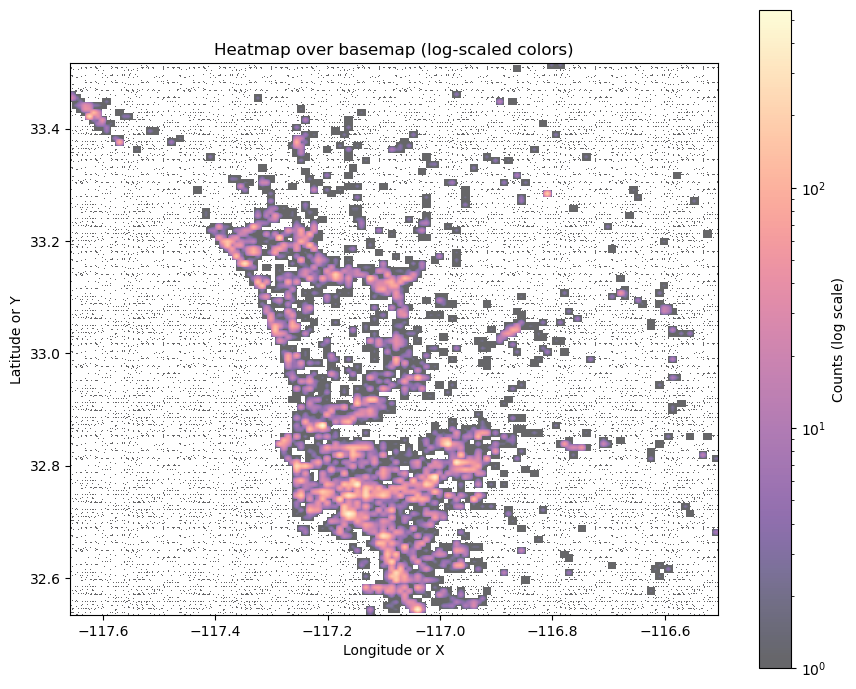

In [12]:
# Fast heatmap over a map background (uses contextily if available)

# prefer longitude as x (map-like)
lon = np.array(longs)
lat = np.array(lats)

# sample for responsiveness
n = len(lon)
if n > 50000:
    idx = np.random.choice(n, size=50000, replace=False)
    lon = lon[idx]; lat = lat[idx]

# try to import contextily/pyproj for basemap tiles
try:
    import contextily as ctx
    from pyproj import Transformer
    has_ctx = True
except Exception as e:
    has_ctx = False

# transform lon/lat (EPSG:4326) to WebMercator (EPSG:3857)
if has_ctx:
    tf = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    mx, my = tf.transform(lon, lat)
else:
    # if no contextily, compute histogram in lon/lat
    mx, my = lon, lat

# compute 2D histogram in the chosen projection
bins = 200 if n <= 50000 else 150
H, xedges, yedges = np.histogram2d(mx, my, bins=bins)

fig, ax = plt.subplots(figsize=(9,7))

# draw basemap if available; try several provider names robustly
if has_ctx:
    zoom = 10
    provider_candidates = [
        'Stamen.TerrainBackground',
        'Stamen.Terrain',
        'Stamen.TonerLite',
        'OpenStreetMap.Mapnik',
        'CartoDB.Positron'
    ]
    img = None
    ext = None
    for pname in provider_candidates:
        # try to get provider by name
        prov = None
        try:
            # ctx.providers behaves like a mapping; prefer .get when available
            if hasattr(ctx.providers, 'get'):
                prov = ctx.providers.get(pname)
            else:
                prov = ctx.providers[pname]
        except Exception:
            prov = None
        if prov is None:
            continue
        try:
            img, ext = ctx.bounds2img(xedges[0], yedges[0], xedges[-1], yedges[-1], zoom=zoom, source=prov)
            used_provider = pname
            break
        except Exception:
            continue
    if img is None:
        # final fallback: try first available provider
        try:
            first_key = list(ctx.providers)[0]
            prov = ctx.providers[first_key]
            img, ext = ctx.bounds2img(xedges[0], yedges[0], xedges[-1], yedges[-1], zoom=zoom, source=prov)
            used_provider = first_key
        except Exception:
            img = None
    if img is not None:
        ax.imshow(img, extent=ext, origin='upper')
        heatmap_extent = ext
    else:
        heatmap_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
else:
    heatmap_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# overlay heatmap with log color scaling and some transparency
nonzero = H[H > 0]
if nonzero.size > 0:
    vmin = max(1, nonzero.min())
else:
    vmin = 1
vmax = max(1, H.max())

ax.imshow(H.T, origin='lower', cmap='magma',
          norm=LogNorm(vmin=vmin, vmax=vmax),
          extent=heatmap_extent,
          alpha=0.6, interpolation='bilinear')

# convert tick labels back to lon/lat if we used WebMercator
if has_ctx:
    inv_tf = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
    mean_my = (yedges[0] + yedges[-1]) / 2
    xticks = np.linspace(xedges[0], xedges[-1], 5)
    try:
        xtick_lons, _ = inv_tf.transform(xticks, np.full_like(xticks, mean_my))
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{v:.3f}" for v in xtick_lons])
    except Exception:
        pass

    mean_mx = (xedges[0] + xedges[-1]) / 2
    yticks = np.linspace(yedges[0], yedges[-1], 5)
    try:
        _, ytick_lats = inv_tf.transform(np.full_like(yticks, mean_mx), yticks)
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{v:.3f}" for v in ytick_lats])
    except Exception:
        pass

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
else:
    ax.set_xlabel('Longitude or X')
    ax.set_ylabel('Latitude or Y')

cb = plt.colorbar(ax.images[-1], ax=ax, label='Counts (log scale)')
ax.set_title('Heatmap over basemap (log-scaled colors)')
plt.tight_layout()

if not has_ctx:
    print('Note: contextily/pyproj not installed. Run `pip install contextily pyproj` to add a map background.')

In [13]:
# %pip install geopandas

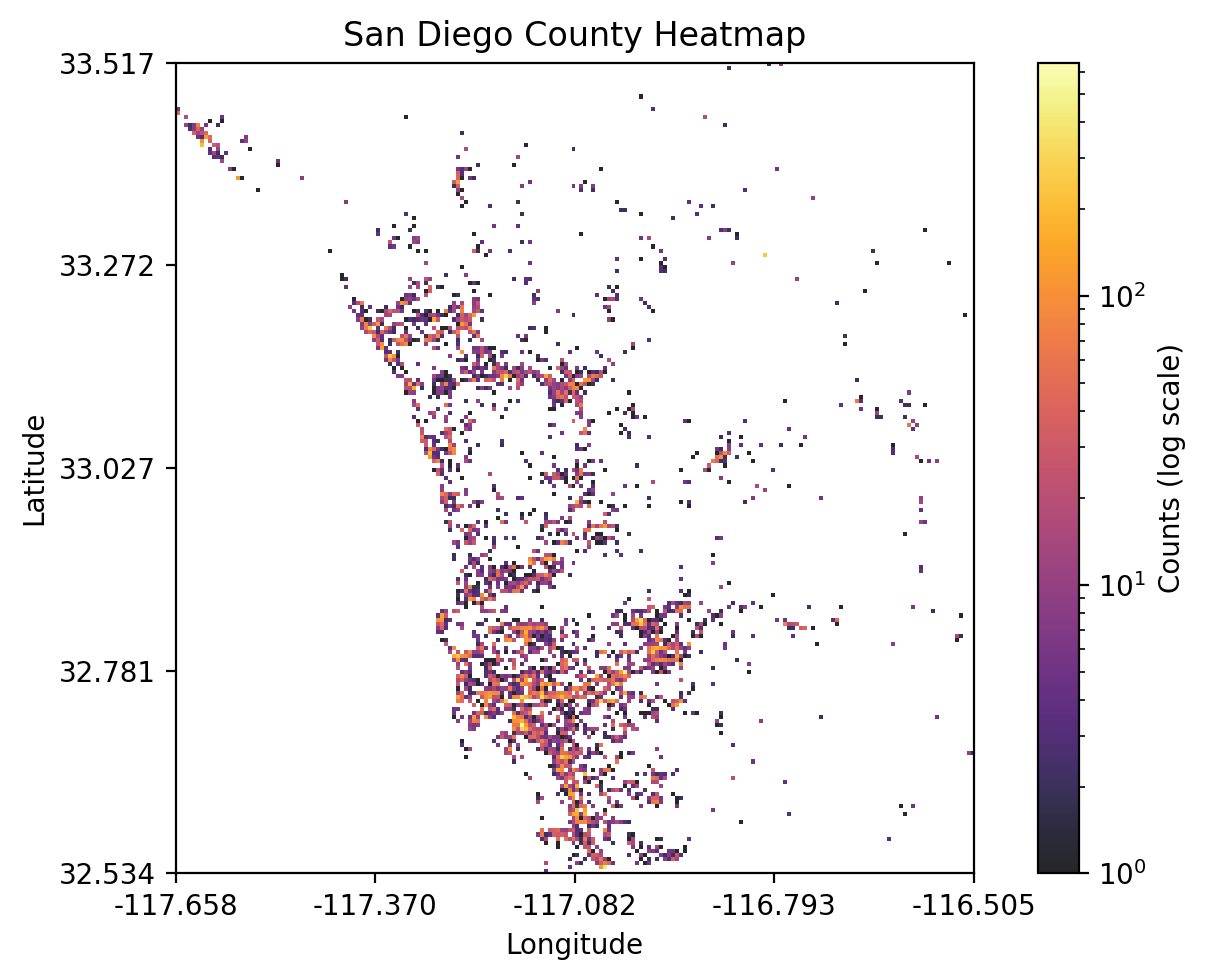

In [42]:
# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
BINS = 200
DPI = 200
ALPHA = 0.85
CMAP = "inferno"

# ---------------------------------------------------------
# 1. CLEAN + FLATTEN lon/lat
# ---------------------------------------------------------
def flatten_numeric(arr):
    arr = np.array(arr, dtype=object).reshape(-1)
    out = []
    for x in arr:
        try:
            if isinstance(x, (float, int, np.floating, np.integer)):
                out.append(float(x))
            elif isinstance(x, (list, tuple, np.ndarray)):
                out.append(float(np.array(x).reshape(-1)[0]))
            else:
                out.append(float(x))
        except:
            continue
    return np.array(out, dtype=float)

lon = flatten_numeric(longs)
lat = flatten_numeric(lats)

m = min(len(lon), len(lat))
lon = lon[:m]
lat = lat[:m]

mask = np.isfinite(lon) & np.isfinite(lat)
lon = lon[mask]
lat = lat[mask]

if len(lon) > 60000:
    idx = np.random.choice(len(lon), 60000, replace=False)
    lon = lon[idx]
    lat = lat[idx]

# ---------------------------------------------------------
# 2. MANUAL WEBMERCATOR PROJECTION
# ---------------------------------------------------------
R = 6378137.0
mx = lon * (R * np.pi/180)

lat_clip = np.clip(lat, -85.05112878, 85.05112878)
my = R * np.log(np.tan(np.pi/4 + np.radians(lat_clip)/2))

mx = mx.reshape(-1)
my = my.reshape(-1)

# ---------------------------------------------------------
# 3. HISTOGRAM
# ---------------------------------------------------------
H, xedges, yedges = np.histogram2d(mx, my, bins=BINS)

# ---------------------------------------------------------
# 4. FIGURE
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(7,5), dpi=DPI)

# ---------------------------------------------------------
# 5. LOAD SAN DIEGO COUNTY SHAPEFILE / GEOJSON
# ---------------------------------------------------------
# IMPORTANT: change this path to your file if needed
# gdf = gpd.read_file("Data/san_diego_boundary_datasd.geojson")

# # Convert lat/lon → WebMercator manually
# def mercator_x(lon):
#     return lon * (R * np.pi/180)

# def mercator_y(lat):
#     lat = np.clip(lat, -85.05112878, 85.05112878)
#     return R * np.log(np.tan(np.pi/4 + np.radians(lat)/2))

# # Project all county polygons manually
# gdf["merc"] = gdf["geometry"].apply(
#     lambda geom: 
#         type(geom)(
#             [(mercator_x(x), mercator_y(y)) for x, y in geom.exterior.coords]
#         )
# )

# # Plot county outline
# for poly in gdf["merc"]:
#     ax.plot(
#         *poly.exterior.xy,
#         color="white",
#         linewidth=1.5,
#         alpha=0.8
#     )

# ---------------------------------------------------------
# 6. CRISP HEATMAP
# ---------------------------------------------------------
nonzero = H[H > 0]
vmin = max(1, nonzero.min()) if nonzero.size else 1
vmax = max(1, H.max())

ax.imshow(
    H.T,
    origin='lower',
    cmap=CMAP,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    alpha=ALPHA,
    interpolation='nearest'
)

# ---------------------------------------------------------
# 7. INVERSE TICKS (Manual WebMercator)
# ---------------------------------------------------------
def inv_merc_x(x): return x / (R * np.pi/180)
def inv_merc_y(y): return np.degrees(2*np.arctan(np.exp(y/R)) - np.pi/2)

xticks = np.linspace(xedges[0], xedges[-1], 5)
yticks = np.linspace(yedges[0], yedges[-1], 5)

ax.set_xticks(xticks)
ax.set_xticklabels([f"{inv_merc_x(v):.3f}" for v in xticks])

ax.set_yticks(yticks)
ax.set_yticklabels([f"{inv_merc_y(v):.3f}" for v in yticks])

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# ---------------------------------------------------------
# 8. COLORBAR + SHOW
# ---------------------------------------------------------
plt.colorbar(ax.images[-1], ax=ax, label="Counts (log scale)")
ax.set_title("San Diego County Heatmap")
plt.tight_layout()
plt.show()


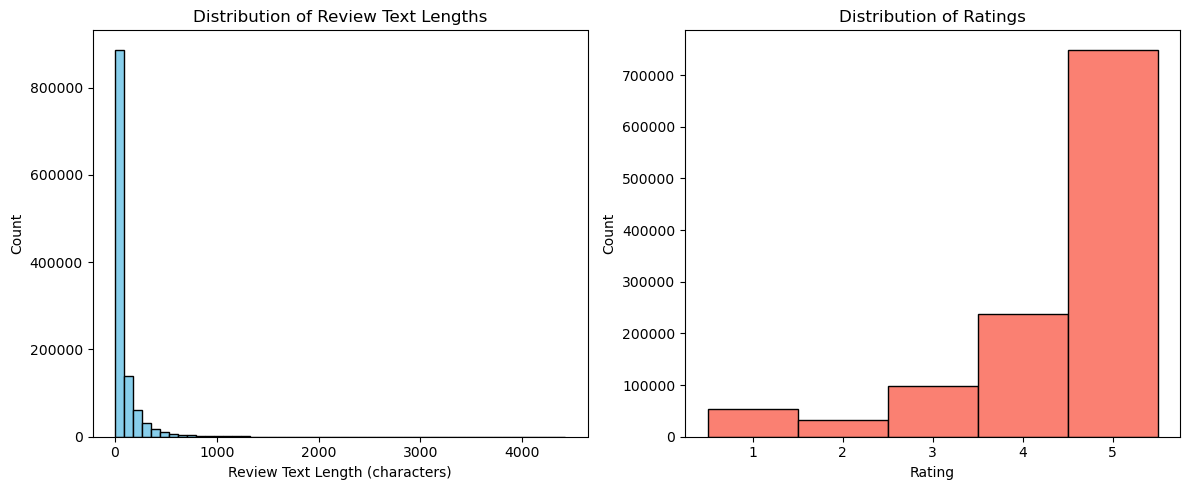

In [15]:
# ---------------------------------------------------------
# 1. Extract review lengths and ratings (clean & safe)
# ---------------------------------------------------------
review_lens = [
    len(r.get("text") or "")
    for r in review_sd
]

ratings = [
    int(r.get("rating", 0))
    for r in review_sd
    if r.get("rating") is not None
]

# Convert to arrays for convenience
review_lens = np.array(review_lens)
ratings = np.array(ratings)

# ---------------------------------------------------------
# 2. HISTOGRAMS: Review Length Distribution + Rating Distribution
# ---------------------------------------------------------
plt.figure(figsize=(12,5))

# Histogram of review lengths
plt.subplot(1,2,1)
plt.hist(review_lens, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Review Text Length (characters)")
plt.ylabel("Count")
plt.title("Distribution of Review Text Lengths")

# Histogram of ratings (discrete 1–5)
plt.subplot(1,2,2)
plt.hist(ratings, bins=np.arange(0.5,6.5,1), color="salmon", edgecolor="black")
plt.xticks([1,2,3,4,5])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")

plt.tight_layout()
plt.show()

C:\Users\issac\AppData\Local\Temp\ipykernel_29684\1338457717.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_stats = df_price.groupby('price')['rating'].agg(['mean','std','count']).reset_index()


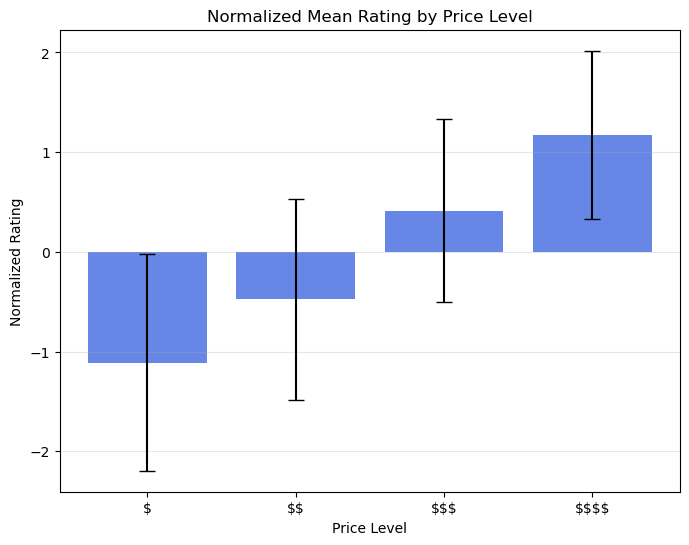

In [16]:
prices = {b['gmap_id']: b['price'] for b in meta_sd if b['price'] != None}


# Extract price and rating pairs safely
rows = []

for r in review_sd:
    gmap = r['gmap_id']
    rating = r.get('rating')

    if rating is None:
        continue

    price = prices.get(gmap)
    if price in ['$','$$','$$$','$$$$']:
        rows.append({'price': price, 'rating': rating})

df_price = pd.DataFrame(rows)

price_order = ['$', '$$', '$$$', '$$$$']
df_price['price'] = pd.Categorical(df_price['price'], categories=price_order, ordered=True)
df_stats = df_price.groupby('price')['rating'].agg(['mean','std','count']).reset_index()
df_stats['normalized_mean'] = (df_stats['mean'] - df_stats['mean'].mean()) / df_stats['mean'].std()
plt.figure(figsize=(8,6))

plt.bar(
    ['\\$','\\$\\$','\\$\\$\\$','\\$\\$\\$\\$'], 
    df_stats['normalized_mean'],
    yerr=df_stats['std'],
    capsize=6,
    color='royalblue',
    alpha=0.8
)

plt.xlabel("Price Level")
plt.ylabel("Normalized Rating")
plt.title("Normalized Mean Rating by Price Level")
plt.grid(axis='y', alpha=0.3)

plt.show()


In [17]:
categories = dict()
for b in meta_sd:
    gmap = b['gmap_id']
    cats = b['category']
    categories[gmap] = cats

In [18]:
# Flatten all categories and get unique values
all_categories = []
for cats in categories.values():
    if cats is not None:
        if isinstance(cats, list):
            all_categories.extend(cats)
        else:
            all_categories.append(cats)
unique_categories = list(set(all_categories))

In [19]:
categories_ratings = defaultdict(list)

for r in review_sd:
    gmap = r['gmap_id']
    rating = r['rating']
    cats = categories[gmap]
    
    if not cats is None:
        for cat in cats:
            categories_ratings[cat].append(rating)

In [20]:
category_stats = {}

for cat, ratings in categories_ratings.items():
    ratings_arr = np.array(ratings, dtype=float)
    weighted_mean = ratings_arr.mean()                # weighted by count
    count = len(ratings_arr)
    category_stats[cat] = (weighted_mean, count)


In [21]:
df_cat = pd.DataFrame([
    {'category': cat, 'weighted_mean': wm, 'num_reviews': n}
    for cat, (wm, n) in category_stats.items()
])

df_cat = df_cat.sort_values('num_reviews', ascending=False)


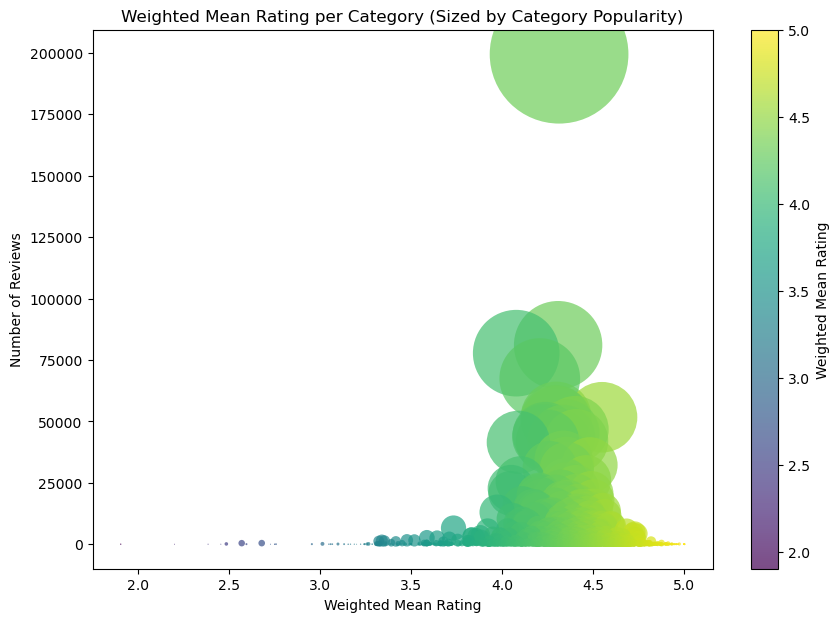

In [22]:
plt.figure(figsize=(10,7))

plt.scatter(
    df_cat['weighted_mean'],
    df_cat['num_reviews'],
    s=df_cat['num_reviews'] / 20,       # bigger = more reviews
    c=df_cat['weighted_mean'],
    cmap='viridis',
    alpha=0.7,
    edgecolors='none'
)

plt.colorbar(label='Weighted Mean Rating')
plt.xlabel("Weighted Mean Rating")
plt.ylabel("Number of Reviews")
plt.title("Weighted Mean Rating per Category (Sized by Category Popularity)")

plt.show()


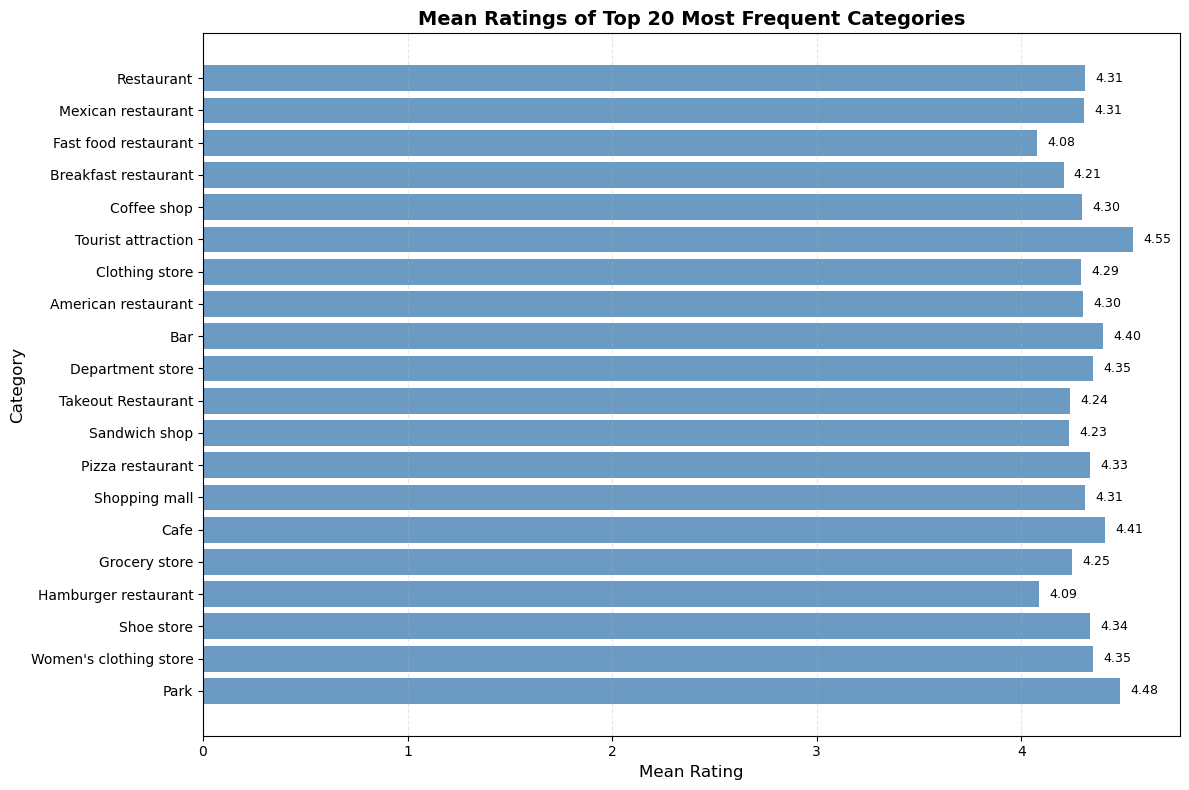

In [23]:
# Get top 20 most frequent categories
top_20_categories = df_cat.head(20)

# Create bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(
    range(len(top_20_categories)),
    top_20_categories['weighted_mean'],
    color='steelblue',
    alpha=0.8
)

# Set y-axis labels to category names
plt.yticks(range(len(top_20_categories)), top_20_categories['category'])
plt.xlabel('Mean Rating', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Mean Ratings of Top 20 Most Frequent Categories', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(top_20_categories.iterrows()):
    plt.text(row['weighted_mean'] + 0.05, i, f"{row['weighted_mean']:.2f}", 
             va='center', fontsize=9)

# Reverse y-axis so highest frequency is at top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


In [24]:
from scipy import stats
from scipy.stats import f_oneway, kruskal

# Prepare data for statistical testing
# Filter out categories with too few ratings (need at least 2 for variance calculation)
# Also filter out None ratings
category_rating_groups = []
category_names = []

for cat, ratings in categories_ratings.items():
    # Filter out None values and convert to float
    clean_ratings = [float(r) for r in ratings if r is not None]
    if len(clean_ratings) >= 2:  # Need at least 2 for statistical test
        category_rating_groups.append(clean_ratings)
        category_names.append(cat)

print(f"Testing relationship between category and rating")
print(f"Number of categories with sufficient data: {len(category_rating_groups)}")
print(f"Total number of ratings: {sum(len(g) for g in category_rating_groups)}\n")

# 1. One-Way ANOVA
# H0: All category means are equal (no relationship)
# H1: At least one category mean differs (relationship exists)
print("=" * 60)
print("1. ONE-WAY ANOVA TEST")
print("=" * 60)
f_statistic, p_value_anova = f_oneway(*category_rating_groups)
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value_anova:.2e}")
print(f"Significance level (α): 0.05")

if p_value_anova < 0.05:
    print(f"✓ REJECT H0: There IS a significant relationship between category and rating (p < 0.05)")
    print(f"  Mean ratings differ significantly across categories.")
else:
    print(f"✗ FAIL TO REJECT H0: No significant relationship found (p ≥ 0.05)")
    print(f"  Mean ratings do not differ significantly across categories.")

# 2. Kruskal-Wallis Test (non-parametric alternative)
# More robust for ordinal data and doesn't assume normality
print("\n" + "=" * 60)
print("2. KRUSKAL-WALLIS TEST (Non-parametric)")
print("=" * 60)
h_statistic, p_value_kw = kruskal(*category_rating_groups)
print(f"H-statistic: {h_statistic:.4f}")
print(f"P-value: {p_value_kw:.2e}")
print(f"Significance level (α): 0.05")

if p_value_kw < 0.05:
    print(f"✓ REJECT H0: There IS a significant relationship between category and rating (p < 0.05)")
    print(f"  Rating distributions differ significantly across categories.")
else:
    print(f"✗ FAIL TO REJECT H0: No significant relationship found (p ≥ 0.05)")
    print(f"  Rating distributions do not differ significantly across categories.")

# Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
if p_value_anova < 0.05 and p_value_kw < 0.05:
    print("Both tests indicate a SIGNIFICANT relationship between category and rating.")
    print("Category is related to rating.")
elif p_value_anova < 0.05 or p_value_kw < 0.05:
    print("One test indicates significance. Results are mixed.")
else:
    print("Both tests indicate NO significant relationship between category and rating.")
    print("Category is NOT significantly related to rating.")

Testing relationship between category and rating
Number of categories with sufficient data: 2304
Total number of ratings: 3569821

1. ONE-WAY ANOVA TEST
F-statistic: 46.1974
P-value: 0.00e+00
Significance level (α): 0.05
✓ REJECT H0: There IS a significant relationship between category and rating (p < 0.05)
  Mean ratings differ significantly across categories.

2. KRUSKAL-WALLIS TEST (Non-parametric)
H-statistic: 108186.5826
P-value: 0.00e+00
Significance level (α): 0.05
✓ REJECT H0: There IS a significant relationship between category and rating (p < 0.05)
  Rating distributions differ significantly across categories.

SUMMARY
Both tests indicate a SIGNIFICANT relationship between category and rating.
Category is related to rating.


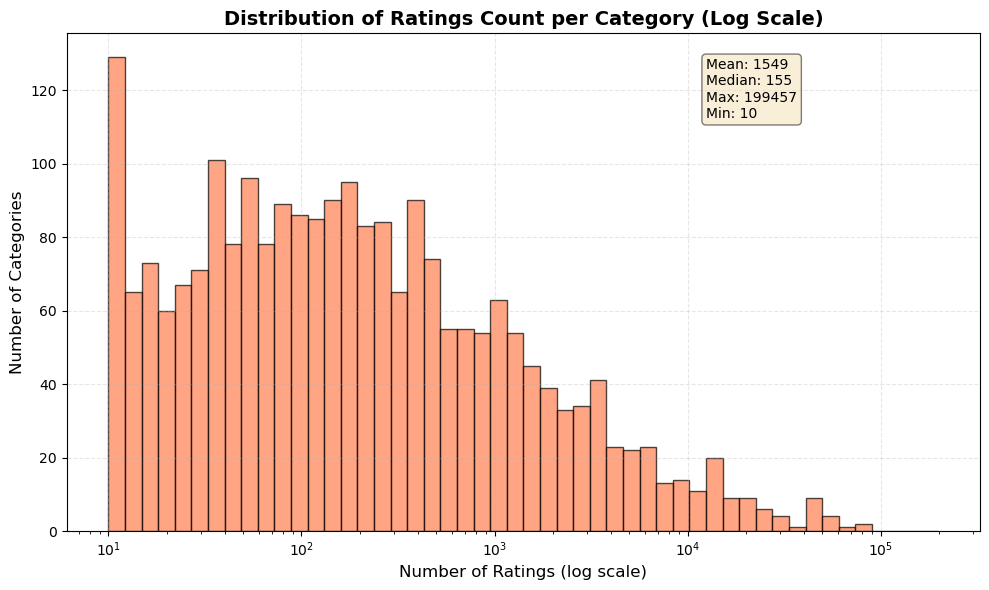

In [25]:
# Histogram of number of ratings per category (log scale with equal log bins)
plt.figure(figsize=(10, 6))

# Create equal-sized log bins
min_ratings = df_cat['num_reviews'].min()
max_ratings = df_cat['num_reviews'].max()
num_bins = 50

# Create bins equally spaced in log space
log_bins = np.logspace(np.log10(min_ratings), np.log10(max_ratings), num_bins + 1)

# Create histogram with log bins
plt.hist(df_cat['num_reviews'], bins=log_bins, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Ratings (log scale)', fontsize=12)
plt.ylabel('Number of Categories', fontsize=12)
plt.title('Distribution of Ratings Count per Category (Log Scale)', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add statistics text
mean_ratings = df_cat['num_reviews'].mean()
median_ratings = df_cat['num_reviews'].median()

stats_text = f'Mean: {mean_ratings:.0f}\nMedian: {median_ratings:.0f}\nMax: {max_ratings:.0f}\nMin: {min_ratings:.0f}'
plt.text(0.7, 0.95, stats_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         fontsize=10)

plt.tight_layout()
plt.show()


In [39]:
top_k_categories = 100  # Change this value to highlight a different cutoff (top-K categories)

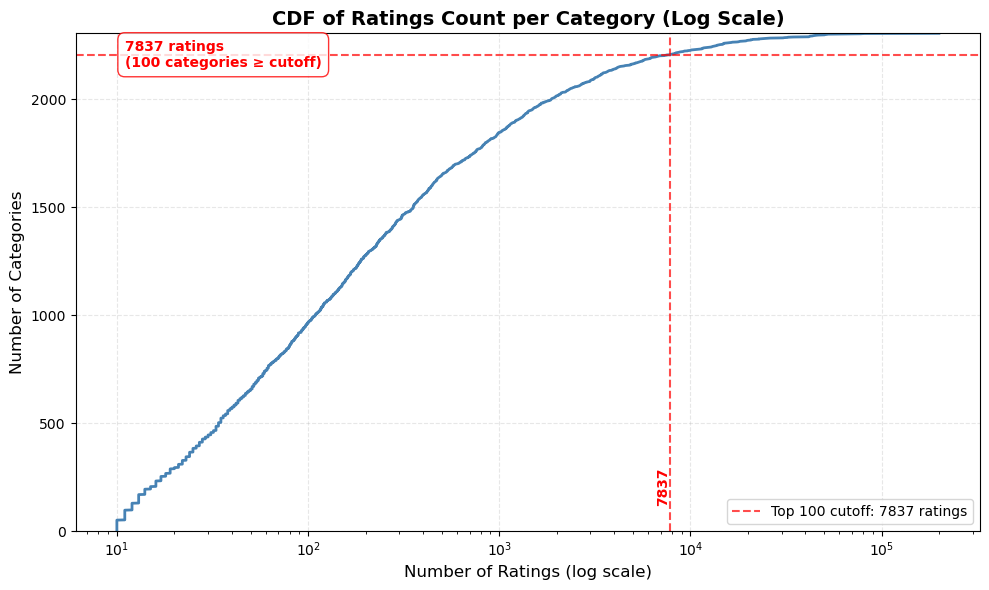

In [40]:
# CDF of number of ratings per category (log scale on x-axis)
# Highlight the cutoff rating needed to be within the top-K most-reviewed categories

plt.figure(figsize=(10, 6))

# Sort the data for CDF
sorted_ratings = np.sort(df_cat['num_reviews'])
n = len(sorted_ratings)

# Clamp top_k_categories in case it exceeds the number of categories
k = max(1, min(int(top_k_categories), n))

# Calculate cumulative count (number of categories)
cumulative_count = np.arange(1, n + 1)

# Plot CDF
plt.plot(sorted_ratings, cumulative_count, linewidth=2, color='steelblue')
plt.xlabel('Number of Ratings (log scale)', fontsize=12)
plt.ylabel('Number of Categories', fontsize=12)
plt.title('CDF of Ratings Count per Category (Log Scale)', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.grid(axis='both', alpha=0.3, linestyle='--')
plt.ylim(0, n)

# Determine the cutoff rating to be among the top-K categories
cutoff_idx = max(0, n - k)
cutoff_value = sorted_ratings[cutoff_idx]
cutoff_count = cumulative_count[cutoff_idx]  # number of categories at/below the cutoff
categories_at_or_above = n - cutoff_idx     # number of categories meeting/exceeding the cutoff

# Add reference lines at the cutoff
cutoff_label = f'Top {k} cutoff: {cutoff_value:.0f} ratings'
plt.axvline(cutoff_value, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=cutoff_label)
plt.axhline(cutoff_count, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Add text labels for the number of ratings and categories
plt.text(cutoff_value, n * 0.05, f'{cutoff_value:.0f}',
         rotation=90, verticalalignment='bottom', horizontalalignment='right',
         fontsize=10, color='red', fontweight='bold')

plt.text(sorted_ratings[0] * 1.1, cutoff_count,
         f'{cutoff_value:.0f} ratings\n({categories_at_or_above} categories ≥ cutoff)',
         verticalalignment='center', horizontalalignment='left',
         fontsize=10, color='red', fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='red'))

plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()
